## Supervised learning: Only Inflow and Outflow

In [ ]:
# Import Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, r2_score
import math
import geopandas as gpd

/root/venv/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [ ]:
import altair as alt

In [ ]:
df_in_out = pd.read_csv('/work/cleaned-csvs/irs_in_out_one_per_county')

us_counties = gpd.read_file('/work/cb_2018_us_county_20m/cb_2018_us_county_20m.shp')
us_counties['COUNTYFP'] = pd.to_numeric(us_counties['COUNTYFP'])
us_counties['STATEFP'] = pd.to_numeric(us_counties['STATEFP'])
us_counties = us_counties[us_counties['STATEFP']==6]

In [ ]:
#this makes the code for ca only. Comment out for all data
df_in_out = df_in_out[df_in_out['statefips']==6]

df_in_out.columns

Index(['statefips', 'countyfips', 'in_2014', 'in_2015', 'in_2016', 'in_2017',
       'in_2018', 'in_2019', 'out_2014', 'out_2015', 'out_2016', 'out_2017',
       'out_2018', 'out_2019'],
      dtype='object')

In [ ]:
train_df = df_in_out[['statefips', 'countyfips', 'in_2014', 
        'in_2015', 'in_2016', 'in_2017',
       'in_2018',  'out_2014', 'out_2015', 'out_2016', 'out_2017',
       'out_2018']]

test_df = df_in_out[['statefips', 'countyfips', 'in_2015', 
        'in_2016', 'in_2017',
       'in_2018', 'in_2019',  'out_2015', 'out_2016', 'out_2017',
       'out_2018', 'out_2019']]



def rename_columns(df, yr_predict):
    start_year = yr_predict - 4
    col_yr = []
    col = []

    for num in range(start_year, yr_predict+1):
        #create list of old and new column names
        col_yr.append('in_'+str(num))
        col.append('in_t_minus_'+str(yr_predict-num))

        col_yr.append('out_'+str(num))
        col.append('out_t_minus_'+str(yr_predict-num))

    
    # create rename dictionary
    col_dict = {col_yr[i]: col[i] for i in range(len(col_yr))}
    
    return(df.rename(columns = col_dict))


train_df = rename_columns(train_df, 2018)
train_df.dropna(inplace = True)

test_df = rename_columns(test_df, 2019)
test_df.dropna(inplace = True)


drop_col = ['statefips', 'countyfips','in_t_minus_0','out_t_minus_0']
X_train = train_df.drop(columns = drop_col)
y_train_out = train_df[['out_t_minus_0']]
y_train_in = train_df[['in_t_minus_0']]

X_test = test_df.drop(columns = drop_col)
y_test_out = test_df[['out_t_minus_0']]
y_test_in = test_df[['in_t_minus_0']]

# Can reduce error in linear model to around 2K root(mean squared error)
# col = ['out_t_minus_4', 'out_t_minus_3', 'out_t_minus_2', 'out_t_minus_1']
# X_train = X_train[col]
# X_test = X_test[col]


## Linear Regression

In [ ]:

# Inflow
regr = LinearRegression()
regr.fit(X_train, y_train_in)
y_pred_in = regr.predict(X_test)
mse_linreg_in = math.sqrt(mean_squared_error(y_test_in, y_pred_in))
r2_svm_in = r2_score(y_test_in, y_pred_in)

# Outflow
regr = LinearRegression()
regr.fit(X_train, y_train_out)
y_pred_out_train = regr.predict(X_train)
y_pred_out = regr.predict(X_test)
mse_linreg_out = math.sqrt(mean_squared_error(y_test_out, y_pred_out))
r2_linreg_out_train = r2_score(y_train_out, y_pred_out_train)
r2_linreg_out = r2_score(y_test_out, y_pred_out)

# The coefficients
#print("Coefficients: \n", regr.coef_)

print('Inflow R^2', r2_svm_in)
print('Inflow mse', mse_linreg_in)
print('Outflow R^2', r2_linreg_out)
print('Outflow R^2 train', r2_linreg_out_train)
print('Outflow mse', mse_linreg_out)

Inflow R^2 0.9875086707749292
Inflow mse 3928.3671921056853
Outflow R^2 0.9441382285223403
Outflow R^2 train 0.9997931241658101
Outflow mse 10467.55143164235


In [ ]:

test_df['y_pred_out']=y_pred_out
test_df['y_pred_in']=y_pred_in

test_df['residual_out'] = test_df['out_t_minus_0'] - test_df['y_pred_out']
test_df['residual_in'] = test_df['in_t_minus_0'] - test_df['y_pred_in']

test_df['perc_off_out'] = test_df['residual_out'] / test_df['out_t_minus_0']
test_df['perc_off_in'] = test_df['residual_in'] / test_df['in_t_minus_0']
test_df.head()


,statefips,countyfips,in_t_minus_4,in_t_minus_3,in_t_minus_2,in_t_minus_1,in_t_minus_0,out_t_minus_4,out_t_minus_3,out_t_minus_2,out_t_minus_1,out_t_minus_0,y_pred_out,y_pred_in,residual_out,residual_in,perc_off_out,perc_off_in
185,6,1,56353.0,74447.0,94743.0,76117.0,73109.0,55460.0,80777.0,111192.0,87475.0,85562.0,105738.562281,81085.239065,-20176.562281,-7976.239065,-0.235812,-0.109101
186,6,3,0.0,51.0,80.0,43.0,49.0,0.0,63.0,84.0,68.0,56.0,255.385921,95.866654,-199.385921,-46.866654,-3.560463,-0.956462
187,6,5,1283.0,1960.0,2775.0,2070.0,2019.0,1040.0,1395.0,1893.0,1619.0,1486.0,2294.172992,2166.087198,-808.172992,-147.087198,-0.543858,-0.072852
188,6,7,5540.0,7572.0,10807.0,7993.0,6449.0,5165.0,7382.0,9275.0,10622.0,14647.0,12833.230720,7684.960352,1813.769280,-1235.960352,0.123832,-0.191651
189,6,9,1676.0,2557.0,3499.0,2834.0,2733.0,1537.0,2040.0,2720.0,2306.0,2281.0,3171.426043,3008.451018,-890.426043,-275.451018,-0.390367,-0.100787


In [ ]:
#join with geospatial data
geo_df = pd.merge(us_counties,test_df,left_on=['STATEFP', 'COUNTYFP'], right_on=['statefips', 'countyfips'])


In [ ]:
geo_df[geo_df['COUNTYFP']==7]
geo_df.sort_values(by='perc_off_out').head(4)

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,...,out_t_minus_3,out_t_minus_2,out_t_minus_1,out_t_minus_0,y_pred_out,y_pred_in,residual_out,residual_in,perc_off_out,perc_off_in
9,6,3,01675840,0500000US06003,06003,Alpine,06,1912292630,12557304,"POLYGON ((-120.07248 38.50987, -120.07239 38.7...",...,63.0,84.0,68.0,56.0,255.385921,95.866654,-199.385921,-46.866654,-3.560463,-0.956462
26,6,91,00277310,0500000US06091,06091,Sierra,06,2468694587,23299110,"POLYGON ((-121.05820 39.53704, -121.00948 39.6...",...,108.0,139.0,129.0,129.0,264.490816,162.861488,-135.490816,-10.861488,-1.050316,-0.071457
0,6,49,00277289,0500000US06049,06049,Modoc,06,10140960152,745420661,"POLYGON ((-121.45721 41.94994, -121.44754 41.9...",...,372.0,426.0,411.0,343.0,625.926514,353.173869,-282.926514,6.826131,-0.824859,0.018961
43,6,15,01682074,0500000US06015,06015,Del Norte,06,2606117983,578742642,"POLYGON ((-124.21959 41.84643, -124.20340 41.9...",...,951.0,1226.0,974.0,811.0,1405.529775,1440.042296,-594.529775,-547.042296,-0.733082,-0.612589


In [ ]:
chart = alt.Chart(geo_df).mark_point().encode(
    x=alt.X('out_t_minus_0',title='Actual outflow'),
    y=alt.Y('y_pred_out', title = 'Predicted outflow'),
    tooltip='NAME'
)

line = pd.DataFrame({
    'out_t_minus_0': [0, 300000],
    'y_pred_out':  [0, 300000],
})

line_plot = alt.Chart(line).mark_line().encode(
    x= 'out_t_minus_0',
    y= 'y_pred_out',
)

(chart + line_plot).properties(title='Predicted outflow systematically over predicts outflow')

alt.LayerChart(...)

In [ ]:
chart = alt.Chart(geo_df).mark_point().encode(
    x=alt.X('in_t_minus_0',title='Actual inflow'),
    y=alt.Y('y_pred_in', title = 'Predicted inflow'),
    tooltip='NAME'
)

line = pd.DataFrame({
    'in_t_minus_0': [0, 200000],
    'y_pred_in':  [0, 200000],
})

line_plot = alt.Chart(line).mark_line().encode(
    x= 'in_t_minus_0',
    y= 'y_pred_in',
)

(chart + line_plot).properties(title='Predicted inflow systematically over predicts inflow')

alt.LayerChart(...)

In [ ]:
alt.Chart(geo_df).mark_geoshape().encode(
    color=alt.Color('perc_off_out',scale=alt.Scale(scheme='blueorange', domain=[-1, 1]),legend=alt.Legend(format=".0%")),
    tooltip=['NAME','perc_off_out']
).properties(height=250,width=150,title='Percent off (close to 0 is good)')

alt.Chart(...)

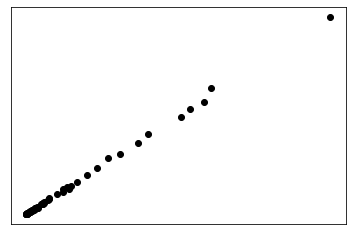

In [ ]:

# Plot outputs
plt.scatter(y_test_in, y_pred_in, color="black")

plt.xticks(())
plt.yticks(())

plt.show()

## Decision Tree Classifier

In [ ]:
from sklearn.tree import plot_tree


clf = DecisionTreeClassifier(random_state=0).fit(X_train, y_train_out)

clf.fit(X_train, y_train_out)

y_pred_out = clf.predict(X_test)


# The mean squared error
print("Square root of mean squared error: %.2f" %  math.sqrt(mean_squared_error(y_test_out, y_pred_out)))

# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.5f" % r2_score(y_test_out, y_pred_out))


Square root of mean squared error: 8185.96
Coefficient of determination: 0.96584


## Random Forrest

In [ ]:
# We assume that having a higher max_depth and a larger n_estimators will create the best result, but we sanity check here.
random_state = 122
parameters = {'n_estimators':[20,50,100], 'max_depth':[2,3,5,8], 'random_state':[random_state]}
rfr = RandomForestRegressor()
reg = GridSearchCV(rfr, parameters)
reg.fit(X_train, y_train_out)
reg.best_estimator_

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681:

RandomForestRegressor(max_depth=5, random_state=122)

In [ ]:
# inflow
rfr = RandomForestRegressor(n_estimators=50, max_depth=5, random_state=random_state)
rfr.fit(X_train, y_train_in)
y_pred_in = rfr.predict(X_test)
rmse_rfr = math.sqrt(mean_squared_error(y_test_in, y_pred_in))
print(r2_score(y_test_in, y_pred_in))

# outflow
rfr = RandomForestRegressor(n_estimators=50, max_depth=5, random_state=random_state)
rfr.fit(X_train, y_train_out)
y_pred_out = rfr.predict(X_test)
rmse_rfr = math.sqrt(mean_squared_error(y_test_out, y_pred_out))
r2_score(y_test_out, y_pred_out)

<ipython-input-16-9b94716ded8a>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr.fit(X_train, y_train_in)
0.9819849228000371
<ipython-input-16-9b94716ded8a>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr.fit(X_train, y_train_out)


0.9597914103789219

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f6c76417-5fde-42f3-8920-755838dec3fa' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>